In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import time
import importlib

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram

In [3]:
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


In [5]:
# qubit layout
vertex_list =  [33, # 0
                32, # 1
                25, 31, # 2, 3
                34, 19, 39, # 4, 5, 6
                30, 35, 18, 45, # 7, 8, 9, 10
                20, 29, 40, 17, 46, # 11, 12, 13, 14, 15
                36, 44, 21, 28, 49, 16, 47, # 16, 17, 18, 19, 20, 21, 22
                24, 11, 37, 43, 12, 27, 50, 15, 53, # 23, 24, 25, 26, 27, 28, 29, 30, 31
                22, 48,  4, 26, 52,  8, 38, 51, 14, 60, # 32, 33, 34, 35, 36, 37, 38, 39, 40, 41
                42, 23,  3, 56,  7, 41, 54, 13, 59, # 42, 43, 44, 45, 46, 47, 48, 49, 50
                 5,  9, 61,  2, 55,  6, 64, 10, 58, # 51, 52, 53, 54, 55, 56, 57, 58, 59
                57, 62,  1, 63,  0] # 60, 61, 62, 63, 64
def is_permutation(seq):
    return len(seq) == len(set(seq))
assert is_permutation(vertex_list)
max_size = len(vertex_list) # largest graph size
shots_per_circuit = 1 << 13 # shots per one execution
system_size = len(vertex_list)

In [6]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 65
system_size: 65
shots_per_circuit: 8192


In [7]:
# indicate how to connect qubits
order = [[0,1], # 2
         [0,2],  [1,3], # 3
         [0,4],  [2,5],  [3,6], # 4
         [3,7],  [4,8],  [5,9],  [6,10], # 5
         [5,11], [7,12], [8,13], [9,14], [10,15], # 6
         [8,16], [10,17],[11,18],[12,19],[13,20],[14,21],[15,22], # 7
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31], # 8
         [18,32],[20,33],[24,34],[25,35],[26,36],[27,37],[28,38],[29,39],[30,40],[31,41], # 9
         [26,42],[32,43],[34,44],[36,45],[37,46],[38,47],[39,48],[40,49],[41,50], # 10
         [34,51],[37,52],[41,53],[44,54],[45,55],[46,56],[48,57],[49,58],[50,59], # 11
         [45,60],[53,61],[54,62],[57,63],[58,64]] # 12

In [8]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7, 7, 7, 7, 7,
                8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                9, 9, 9, 9, 9, 9, 9, 9, 9,
                10,10,10,10,10,10,10,10,10,
                11,11,11,11,11]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11]
65


In [9]:
def ghz_state(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    if size <= 1:
        qc.measure_all()
        return qc
    qc.h(0)
    depth = 0
    for i, j in order:
        if depth != qubit_depths[j]:
            qc.barrier()
            depth += 1
        qc.cx(i, j)
    qc.barrier()
    qc.measure_all()
    return qc

In [10]:
qcs = [ghz_state(size, order[:size-1], qubit_depths[:size]) for size in range(1, max_size+1)]

In [11]:
def make_qcs_list(qcs):
    qcs_list = []
    mit_patterns = []
    for i in range(len(qcs)):
        qr = QuantumRegister(qcs[i].num_qubits)
        mit_pattern = [[i] for i in range(qcs[i].num_qubits)]
        meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
        qcs_list.append(qcs[i])
        qcs_list += meas_calibs
        mit_patterns.append(mit_pattern)
    return qcs_list, mit_patterns

In [12]:
qcs_list, mit_patterns = make_qcs_list(qcs)
print(len(qcs_list), len(mit_patterns))

195 65


In [ ]:
initial_layouts = []
for i in range(len(qcs_list)):
    initial_layouts.append( vertex_list[:qcs_list[i].num_qubits] )

In [7]:
device = provider.backend.ibmq_brooklyn
backend = provider.get_backend('ibmq_brooklyn')

In [15]:
job = execute(qcs_list,
               backend=backend, 
               shots=shots_per_circuit,
               optimization_level=1,
               initial_layout=initial_layouts)
print("job id:", job.job_id())
# job id: 612236919d8e994b6ff37708

'\njob = execute(qcs_list,\n               backend=backend, \n               shots=shots_per_circuit,\n               optimization_level=1,\n               initial_layout=initial_layouts)\nprint("job id:", job.job_id())\n'

In [ ]:
import pickle
job_ids = ["612236919d8e994b6ff37708"]
with open("pkls/jobs.pkl", "wb") as f:
    pickle.dump(job_ids, f)

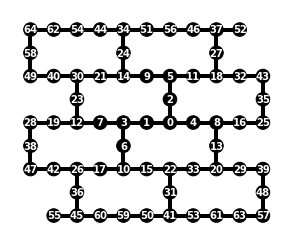

In [17]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
backend = provider.get_backend('ibmq_brooklyn')
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)